In [6]:

import time
import numpy as np
import mxnet as mx
from tqdm import tqdm, tqdm_notebook
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def gpu_exists():
    try:
        mx.nd.zeros((1,), ctx=mx.gpu(0))
    except:
        return False
    return True

data_ctx = mx.cpu()
if gpu_exists():
    print('Using GPU for model_ctx')
    model_ctx = mx.gpu(0)
else:
    print('Using CPU for model_ctx')
    model_ctx = mx.cpu()

Using CPU for model_ctx


In [8]:

mx.random.seed(1)
output_fig = False

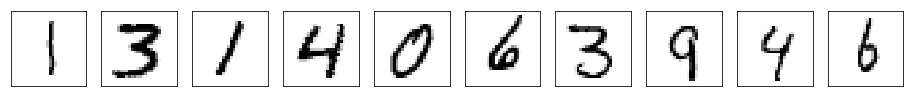

In [9]:
#load mnist
mnist = mx.test_utils.get_mnist()
#print(mnist['train_data'][0].shape)
#plt.imshow(mnist['train_data'][0][0],cmap='Greys')

n_samples = 10
idx = np.random.choice(len(mnist['train_data']), n_samples)
_, axarr = plt.subplots(1, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[i].imshow(mnist['train_data'][j][0], cmap='Greys')
    #axarr[i].axis('off')
    axarr[i].get_xaxis().set_ticks([])
    axarr[i].get_yaxis().set_ticks([])
plt.show()

In [11]:

train_data = np.reshape(mnist['train_data'],(-1,28*28))
test_data = np.reshape(mnist['test_data'],(-1,28*28))

In [12]:
idx = np.random.choice(len(mnist['train_data']), n_samples)


In [13]:
batch_size = 100
n_batches = train_data.shape[0]/batch_size
train_iter = mx.io.NDArrayIter(data={'data': train_data}, label={'label': mnist['train_label']}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': test_data}, label={'label': mnist['test_label']}, batch_size = batch_size)
#train_iter = mx.io.NDArrayIter(data={'data': train_data}, batch_size = batch_size)
#test_iter = mx.io.NDArrayIter(data={'data': test_data}, batch_size = batch_size)


In [14]:
class VAE(gluon.HybridBlock):
    def __init__(self, n_hidden=400, n_latent=2, n_layers=1, n_output=784, batch_size=100, act_type='relu', **kwargs):
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.output = None
        self.mu = None
        # note to self: requring batch_size in model definition is sad, not sure how to deal with this otherwise though
        super(VAE, self).__init__(**kwargs)
        # self.use_aux_logits = use_aux_logits
        with self.name_scope():
            self.encoder = nn.HybridSequential(prefix='encoder')
            for i in range(n_layers):
                self.encoder.add(nn.Dense(n_hidden, activation=act_type))
            self.encoder.add(nn.Dense(n_latent*2, activation=None))

            self.decoder = nn.HybridSequential(prefix='decoder')
            for i in range(n_layers):
                self.decoder.add(nn.Dense(n_hidden, activation=act_type))
            self.decoder.add(nn.Dense(n_output, activation='sigmoid'))

    def hybrid_forward(self, F, x):
        h = self.encoder(x)
        #print(h)
        mu_lv = F.split(h, axis=1, num_outputs=2)
        mu = mu_lv[0]
        lv = mu_lv[1]
        self.mu = mu
        #eps = F.random_normal(loc=0, scale=1, shape=mu.shape, ctx=model_ctx)
        # this would work fine only for nd (i.e. non-hybridized block)
        eps = F.random_normal(loc=0, scale=1, shape=(self.batch_size, self.n_latent), ctx=model_ctx)
        z = mu + F.exp(0.5*lv)*eps
        y = self.decoder(z)
        self.output = y

        KL = 0.5*F.sum(1+lv-mu*mu-F.exp(lv),axis=1)
        logloss = F.sum(x*F.log(y+self.soft_zero)+ (1-x)*F.log(1-y+self.soft_zero), axis=1)
        loss = -logloss-KL

        return loss

In [15]:
n_hidden=400
n_latent=2
n_layers=2 # num of dense layers in encoder and decoder respectively
n_output=784
model_prefix = 'vae_gluon_{}d{}l{}h.params'.format(n_latent, n_layers, n_hidden)

net = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, n_output=n_output, batch_size=batch_size)


In [16]:
net.collect_params().initialize(mx.init.Xavier(), ctx=model_ctx)
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .001})

In [17]:
n_epoch = 50
print_period = n_epoch // 10
start = time.time()

training_loss = []
validation_loss = []
for epoch in tqdm_notebook(range(n_epoch), desc='epochs'):
    epoch_loss = 0
    epoch_val_loss = 0

    train_iter.reset()
    test_iter.reset()

    n_batch_train = 0
    for batch in train_iter:
        n_batch_train +=1
        data = batch.data[0].as_in_context(model_ctx)
        with autograd.record():
            loss = net(data)
        loss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(loss).asscalar()

    n_batch_val = 0
    for batch in test_iter:
        n_batch_val +=1
        data = batch.data[0].as_in_context(model_ctx)
        loss = net(data)
        epoch_val_loss += nd.mean(loss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    if epoch % max(print_period,1) == 0:
        tqdm.write('Epoch{}, Training loss {:.2f}, Validation loss {:.2f}'.format(epoch, epoch_loss, epoch_val_loss))

end = time.time()
print('Time elapsed: {:.2f}s'.format(end - start))

Epoch0, Training loss 186.26, Validation loss 172.32
Epoch5, Training loss 150.06, Validation loss 151.55
Epoch10, Training loss 144.65, Validation loss 146.39
Epoch15, Training loss 142.04, Validation loss 143.97
Epoch20, Training loss 140.92, Validation loss 143.69
Epoch25, Training loss 139.47, Validation loss 142.55
Epoch30, Training loss 139.46, Validation loss 141.91
Epoch35, Training loss 137.88, Validation loss 140.83
Epoch40, Training loss 137.78, Validation loss 140.47
Epoch45, Training loss 137.03, Validation loss 140.44

Time elapsed: 898.88s


In [18]:
net.save_parameters(model_prefix)

In [ ]:
batch_x = np.linspace(1, n_epoch, len(training_loss))
plt.plot(batch_x, -1*np.array(training_loss))
plt.plot(batch_x, -1*np.array(validation_loss))
plt.legend(['train', 'valid'])

In [ ]:
net2 = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, n_output=n_output, batch_size=batch_size)
net2.load_parameters(model_prefix, ctx=model_ctx)

In [ ]:
test_iter.reset()
test_batch = test_iter.next()
net2(test_batch.data[0].as_in_context(model_ctx))
result = net2.output.asnumpy()
original = test_batch.data[0].asnumpy()

In [ ]:
n_samples = 10
idx = np.random.choice(batch_size, n_samples)
_, axarr = plt.subplots(2, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[0,i].imshow(original[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[0,i].set_title('original')
    #axarr[0,i].axis('off')
    axarr[0,i].get_xaxis().set_ticks([])
    axarr[0,i].get_yaxis().set_ticks([])

    axarr[1,i].imshow(result[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[1,i].set_title('reconstruction')
    #axarr[1,i].axis('off')
    axarr[1,i].get_xaxis().set_ticks([])
    axarr[1,i].get_yaxis().set_ticks([])
plt.show()

In [ ]:
n_batches = 10
counter = 0
results = []
labels = []
for batch in test_iter:
    net2(batch.data[0].as_in_context(model_ctx))
    results.append(net2.mu.asnumpy())
    labels.append(batch.label[0].asnumpy())
    counter +=1
    if counter >= n_batches:
        break

In [ ]:
result= np.vstack(results)
labels = np.hstack(labels)

In [ ]:
if result.shape[1]==2:
    from scipy.special import ndtri
    from scipy.stats import norm

    fig, axarr = plt.subplots(1,2, figsize=(10,4))
    im=axarr[0].scatter(result[:, 0], result[:, 1], c=labels, alpha=0.6, cmap='Paired')
    axarr[0].set_title(r'scatter plot of $\mu$')
    axarr[0].axis('equal')
    fig.colorbar(im, ax=axarr[0])

    im=axarr[1].scatter(norm.cdf(result[:, 0]), norm.cdf(result[:, 1]), c=labels, alpha=0.6, cmap='Paired')
    axarr[1].set_title(r'scatter plot of $\mu$ on norm.cdf() transformed coordinates')
    axarr[1].axis('equal')
    fig.colorbar(im, ax=axarr[1])
    plt.tight_layout()
    if output_fig:
        plt.savefig('2d_latent_space_for_test_samples.png')

In [ ]:
n_samples = 10
zsamples = nd.array(np.random.randn(n_samples*n_samples, n_latent))


In [ ]:
images = net2.decoder(zsamples.as_in_context(model_ctx)).asnumpy()

In [ ]:
canvas = np.empty((28*n_samples, 28*n_samples))
for i, img in enumerate(images):
    x = i // n_samples
    y = i % n_samples
    canvas[(n_samples-y-1)*28:(n_samples-y)*28, x*28:(x+1)*28] = img.reshape(28, 28)
plt.figure(figsize=(4, 4))
plt.imshow(canvas, origin="upper", cmap="Greys")
plt.axis('off')
plt.tight_layout()
if output_fig:
    plt.savefig('generated_samples_with_{}D_latent_space.png'.format(n_latent))

In [ ]:
if n_latent==2:
    n_pts = 20

    idx = np.arange(0, n_pts)

    x = np.linspace(norm.cdf(-3), norm.cdf(3),n_pts)
    x = ndtri(x)

    x_grid = np.array(np.meshgrid(*[i for i in np.matlib.repmat(x,n_latent,1)]))
    id_grid = np.array(np.meshgrid(*[i for i in np.matlib.repmat(idx,n_latent,1)]))

    zsamples = nd.array(x_grid.reshape((n_latent, -1)).transpose())
    zsamples_id = id_grid.reshape((n_latent, -1)).transpose()

    images = net2.decoder(zsamples.as_in_context(model_ctx)).asnumpy()

    #plot
    canvas = np.empty((28*n_pts, 28*n_pts))
    for i, img in enumerate(images):
        x, y = zsamples_id[i]
        canvas[(n_pts-y-1)*28:(n_pts-y)*28, x*28:(x+1)*28] = img.reshape(28, 28)
    plt.figure(figsize=(6, 6))
    plt.imshow(canvas, origin="upper", cmap="Greys")
    plt.axis('off')
    plt.tight_layout()
    if output_fig:
        plt.savefig('2d_latent_space_scan_for_generation.png')